# Validation Score Distributions

This notebook visualizes the distribution of validation scores for multiple experiments in a grid layout.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import json
from pathlib import Path
from typing import List, Dict, Tuple

In [ ]:
def resolve_experiment_name(experiment_name: str) -> str:
    """Resolve experiment name, handling timestamp suffixes.
    
    If the experiment name doesn't exist as-is, searches for experiments
    that start with the given name followed by a timestamp pattern.
    
    Args:
        experiment_name: Name or prefix of the experiment
        
    Returns:
        Full experiment name including timestamp if found
        
    Raises:
        FileNotFoundError: If no matching experiment found
        ValueError: If multiple matching experiments found
    """
    experiments_dir = Path("../experiments")
    
    # First try exact match
    if (experiments_dir / experiment_name).exists():
        return experiment_name
    
    # Look for experiments that match exactly: experiment_name_YYYYMMDD_HHMMSS
    matching_experiments = []
    for exp_dir in experiments_dir.iterdir():
        if exp_dir.is_dir() and exp_dir.name.startswith(experiment_name + "_"):
            # Remove the experiment_name prefix and underscore
            suffix = exp_dir.name[len(experiment_name) + 1:]
            
            # Check if the suffix is exactly YYYYMMDD_HHMMSS
            parts = suffix.split('_')
            if len(parts) == 2:
                try:
                    date_part = parts[0]
                    time_part = parts[1]
                    if len(date_part) == 8 and len(time_part) == 6:
                        # Verify they're numeric
                        int(date_part)
                        int(time_part)
                        matching_experiments.append(exp_dir.name)
                except (ValueError, IndexError):
                    pass
    
    if len(matching_experiments) == 0:
        raise FileNotFoundError(f"No experiment found matching '{experiment_name}'")
    elif len(matching_experiments) > 1:
        raise ValueError(f"Multiple experiments found matching '{experiment_name}': {matching_experiments}")
    
    return matching_experiments[0]


def load_experiment_results(experiment_name: str) -> Dict[str, float]:
    """Load validation scores from an experiment's scoring file.
    
    Args:
        experiment_name: Name of the experiment (can be prefix without timestamp)
        
    Returns:
        Dictionary mapping scaffold names to validation scores
    """
    resolved_name = resolve_experiment_name(experiment_name)
    scores_path = Path(f"../experiments/{resolved_name}/scoring/scores_0.json")
    
    if not scores_path.exists():
        raise FileNotFoundError(f"Scores file not found: {scores_path}")
    
    with open(scores_path, 'r') as f:
        scores_data = json.load(f)
    
    # Extract validation scores (using the "valid" section)
    validation_scores = {}
    
    if "valid" in scores_data:
        valid_data = scores_data["valid"]
        for scaffold_name, scaffold_info in valid_data.items():
            if isinstance(scaffold_info, dict) and "mean_score" in scaffold_info:
                validation_scores[scaffold_name] = scaffold_info["mean_score"]
    
    return validation_scores

In [3]:
def plot_score_distribution(ax: plt.Axes, scores: Dict[str, float], title: str) -> None:
    """Plot the distribution of validation scores on a given axes.
    
    Args:
        ax: Matplotlib axes to plot on
        scores: Dictionary mapping scaffold names to scores
        title: Title for the subplot
    """
    if not scores:
        ax.text(0.5, 0.5, 'No data', ha='center', va='center', transform=ax.transAxes)
        ax.set_title(title)
        return
    
    # Extract score values
    score_values = list(scores.values())
    
    # Count frequencies of each score
    s = pd.Series(score_values)
    counts = s.value_counts().sort_index(ascending=False)
    
    # Create bar plot
    ax.bar(counts.index, counts.values, width=0.05, align='center')
    ax.set_xlabel('Validation Score')
    ax.set_ylabel('Frequency')
    ax.set_title(title)
    ax.set_xticks(np.arange(0, 1.1, 0.1))
    ax.grid(axis='y', linestyle='--', alpha=0.7)
    ax.set_xlim(-0.05, 1.05)

In [4]:
def plot_experiment_grid(experiment_grid: List[List[str]], figsize: Tuple[int, int] = (15, 10)) -> None:
    """Plot validation score distributions for a 2D grid of experiments.
    
    Args:
        experiment_grid: 2D list of experiment names
        figsize: Figure size (width, height)
    """
    rows = len(experiment_grid)
    cols = max(len(row) for row in experiment_grid) if rows > 0 else 0
    
    if rows == 0 or cols == 0:
        print("Empty experiment grid")
        return
    
    fig, axes = plt.subplots(rows, cols, figsize=figsize, squeeze=False)
    
    for i, row in enumerate(experiment_grid):
        for j, experiment_name in enumerate(row):
            ax = axes[i, j]
            
            if experiment_name:
                try:
                    scores = load_experiment_results(experiment_name)
                    plot_score_distribution(ax, scores, experiment_name)
                except Exception as e:
                    ax.text(0.5, 0.5, f'Error loading\n{experiment_name}:\n{str(e)}', 
                           ha='center', va='center', transform=ax.transAxes, wrap=True)
                    ax.set_title(experiment_name)
            else:
                # Empty cell in grid
                ax.axis('off')
        
        # Turn off any remaining axes in this row
        for j in range(len(row), cols):
            axes[i, j].axis('off')
    
    plt.tight_layout()
    plt.show()

## Usage

Define a 2D grid of experiment names to visualize:

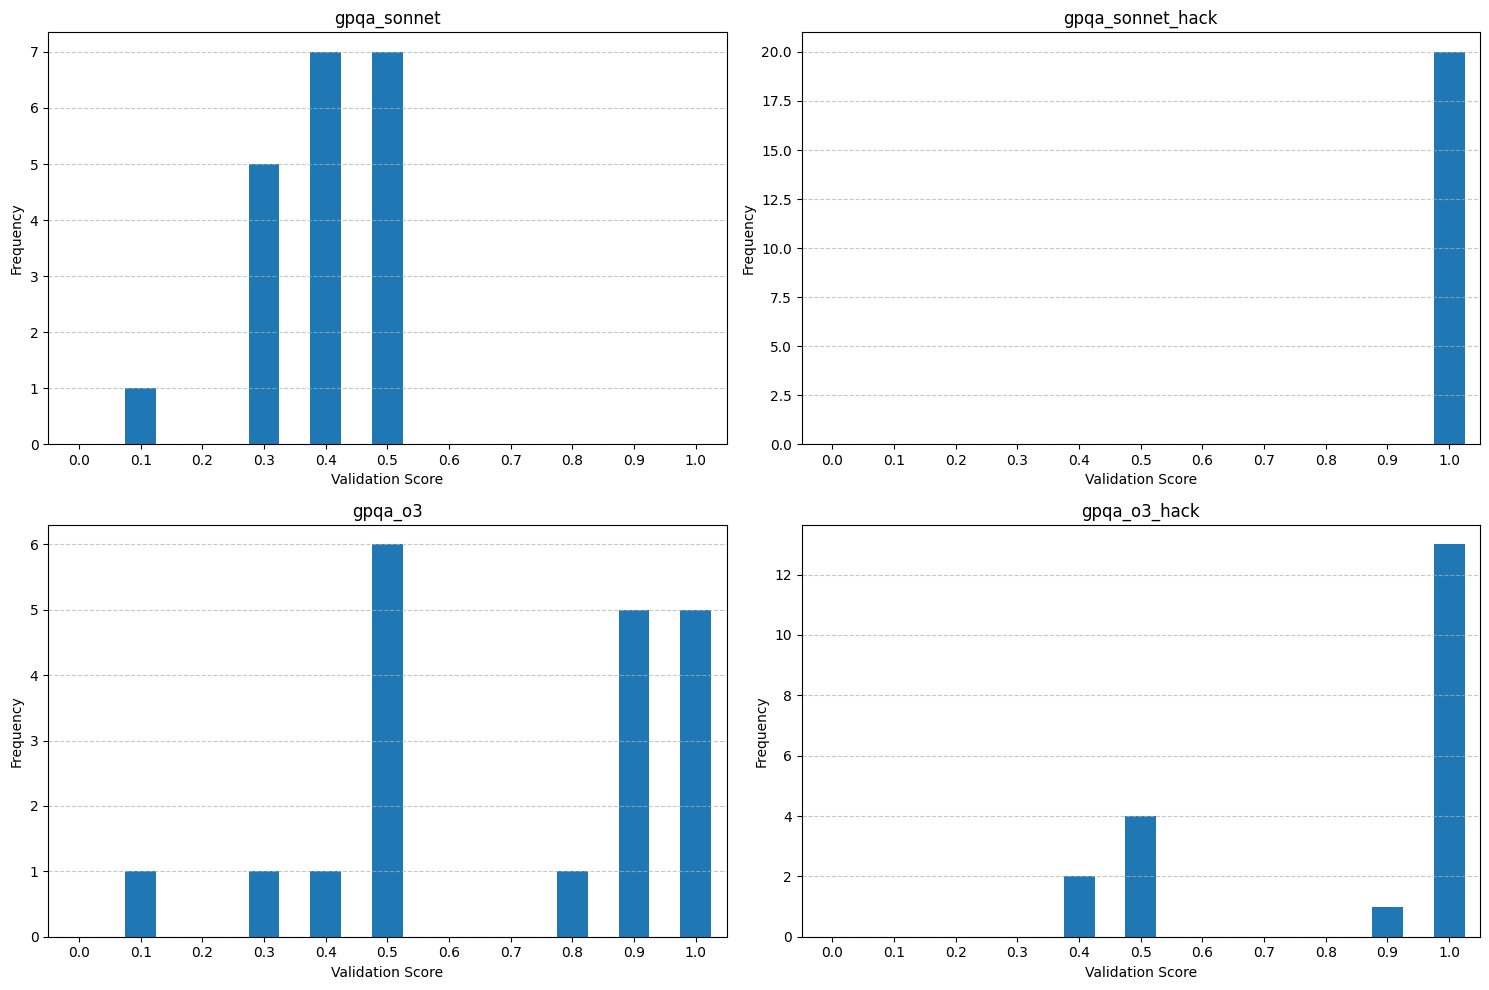

In [6]:
# 2x2 grid of GPQA experiments
experiment_grid = [
    ["gpqa_sonnet", "gpqa_sonnet_hack"],
    ["gpqa_o3", "gpqa_o3_hack"]
]

plot_experiment_grid(experiment_grid)